In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

### Select a real spectrum with a strong Halpha emissions line from SDSS (what's the object?)

Set the coordinates for the object

In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord

ra = 229.525575754 * u.degree
dec = 42.745853761 * u.degree
coords = SkyCoord(ra, dec)

### Construct a `synphot` source spectrum object from the empirical spectrum:

Retrieve the observed spectrum from SDSS

In [3]:
from astroquery.sdss import SDSS
from synphot import units

spectrum_fits = SDSS.get_spectra(coordinates=coords)
data = spectrum_fits[0][1].data

wavelengths = 10 ** data['loglam'] * u.angstrom
flux = data['flux'] * units.FLAM

/Users/tiffanyjansen/anaconda3/lib/python3.7/site-packages/astroquery/sdss/__init__.py:29: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "
/Users/tiffanyjansen/anaconda3/lib/python3.7/site-packages/astroquery/sdss/core.py:856: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


Make the source spectrum object with <a href="https://synphot.readthedocs.io/en/latest/synphot/spectrum.html#arrays">SourceSpectrum</a>:

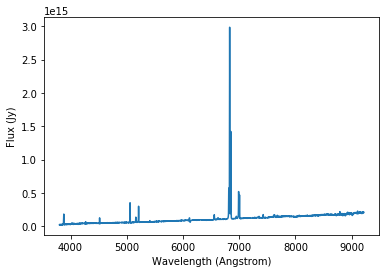

In [4]:
from synphot.spectrum import SourceSpectrum
from synphot.models import Empirical1D

spectrum = SourceSpectrum(Empirical1D,
                          points=wavelengths, lookup_table=flux)
spectrum.plot(flux_unit='Jy')

### Model the bandpasses

We query the SDSS filter transmission functions from <a href="http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=voservice">SVO</a> using the <a href="https://tynt.readthedocs.io/en/latest/index.html">tynt</a> package. These transmission functions include the effect of the CCD's quantum efficiency on the spectrum.

To construct a bandpass from an array with `synphot`, use <a href="https://synphot.readthedocs.io/en/latest/api/synphot.spectrum.SpectralElement.html#synphot.spectrum">SpectralElement</a> with the Empirical1D model:

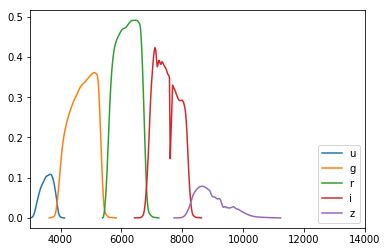

In [7]:
import tynt
from synphot.spectrum import SpectralElement

sdss_bands = ['u', 'g', 'r', 'i', 'z']

f = tynt.FilterGenerator()

bandpasses = {}
for band in sdss_bands:
    filt = f.download_true_transmittance('SLOAN/SDSS.' + band)
    bp = SpectralElement(Empirical1D,
                         points=filt.wavelength,
                         lookup_table=filt.transmittance)
    bandpasses[band] = bp
    
    plt.plot(bp.waveset, bp(bp.waveset), label=band)
plt.legend(loc='lower right')
plt.xlim(3000, 14000)
plt.show()

You can also construct a bandpass from a file using <tt>synphot</tt>'s <a href="https://synphot.readthedocs.io/en/latest/api/synphot.spectrum.SpectralElement.html#synphot.spectrum.SpectralElement.from_file">SpectralElement.from_file()</a>

<a id="atmosphere"></a>
### Model the attenuation by the atmosphere

Model the atmospheric transmittance using the local script `skymodel.py`, which queries results from the <a href="http://etimecalret-001.eso.org/observing/etc/bin/gen/form?INS.MODE=swspectr+INS.NAME=SKYCALC">SkyCalc Sky Model Calculator</a>:

In [8]:
import skymodel

trans_waves, transmission = skymodel.get_atmospheric_transmittance()

Use `synphot` to convolve the atmospheric effects with other parts of the observation:

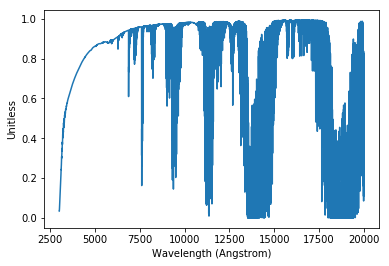

In [9]:
atmosphere = SpectralElement(Empirical1D,
                             points=trans_waves,
                             lookup_table=transmission)
atmosphere.plot()

### Model the observation

Set up the telescope specs.

In the case of fiberMag we use an aperture appropriate to the SDSS spectrograph (3′′ in diameter) according to <a href="https://www.sdss.org/dr12/algorithms/magnitudes/">this page</a> on the SDSS website.

In [10]:
import astropy.units.imperial as imp

aperture_radius = (3 / 2) * imp.inch
aperture_area = np.pi * aperture_radius ** 2

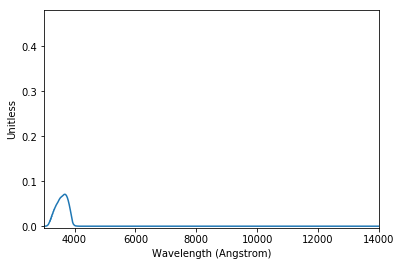

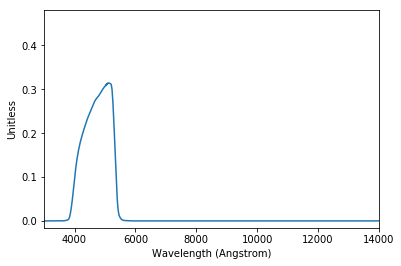

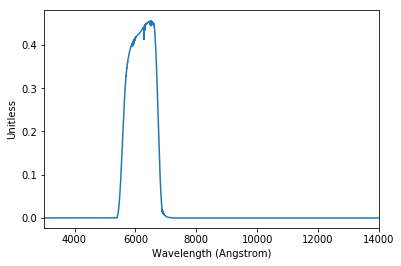

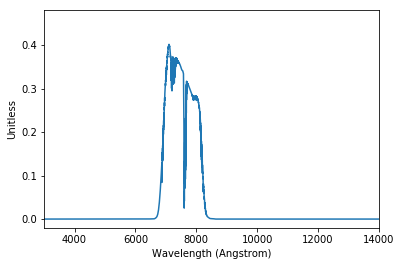

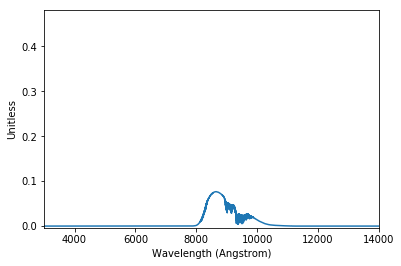

In [11]:
bp_atmos_qe = {} # setting up a dictionary for the different SDSS bands
for band in sdss_bands:
    bp_atmos_qe[band] = bandpasses[band] * atmosphere
    
    bp_atmos_qe[band].plot(left=3000, right=14000, top=0.48)

In [12]:
from synphot.observation import Observation

observations = {}
for band in sdss_bands:
    observations[band] = Observation(spectrum, bp_atmos_qe[band], force='taper')

To get the expected count rate for a specific collecting area, use the <a href="https://synphot.readthedocs.io/en/latest/api/synphot.observation.Observation.html#synphot.observation.Observation.countrate">countrate()</a> method on the observation object: 

In [13]:
countrates = [observations[band].countrate(area=aperture_area).value for band in sdss_bands]
countrates

[<Quantity 2.6969147e+15 ct / s>,
 <Quantity 2.69247986e+17 ct / s>,
 <Quantity 5.14554858e+17 ct / s>,
 <Quantity 5.47860691e+17 ct / s>,
 <Quantity 8.58360233e+16 ct / s>]

### Compare the u,g,r,i,z empirical magnitudes to what we predict with synphot

Get the magnitudes measured by the SDSS fibers

In [20]:
fiber_mags = ['fiberMag_' + band for band in sdss_bands]
mag_table = SDSS.query_crossid(coordinates = coords, photoobj_fields=fiber_mags)

In [21]:
mag_table

obj_id,objID,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,obj_id1,type
bytes5,int64,float64,float64,float64,float64,float64,int64,bytes6
obj_0,1237662301903192106,18.43611,17.3877,16.79793,16.32855,15.95897,1237662301903192106,GALAXY
